### Throughout the exercises for Regression in Python lessons, you will use the following example scenario: As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of 5.00 dollars per customer.


The first step will be to acquire and prep the data. Do your work for this exercise in a file named wrangle.py.



In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import host, user, password

from sklearn.model_selection import train_test_split

In [2]:
import wrangle

1. Acquire customer_id, monthly_charges, tenure, and total_charges from telco_churn database for all customers with a 2 year contract.


In [3]:
sql_query = '''select customer_id, monthly_charges, tenure, total_charges
    from customers
    join contract_types using(contract_type_id)
    where contract_type = "Two Year"
    '''
connection = f'mysql+pymysql://{user}:{password}@{host}/telco_churn'
df = pd.read_sql(sql_query, connection)

2. Walk through the steps above using your new dataframe. You may handle the missing values however you feel is appropriate.


In [4]:
df.head(10)
# no issues spotted so far

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.8
2,0016-QLJIS,90.45,65,5957.9
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75
5,0019-EFAEP,101.30,72,7261.25
6,0019-GFNTW,45.05,56,2560.1
7,0020-INWCK,95.75,71,6849.4
8,0040-HALCW,20.40,54,1090.6
9,0042-RLHYP,19.70,69,1396.9


In [5]:
df.shape
# 1695 rows and 4 columns

(1695, 4)

In [6]:
df.describe()
#looking good still

,monthly_charges,tenure
count,1695.000000,1695.000000
mean,60.770413,56.735103
std,34.678865,18.209363
min,18.400000,0.000000
25%,24.025000,48.000000
50%,64.350000,64.000000
75%,90.450000,71.000000
max,118.750000,72.000000


In [7]:
df.info()
# all columns have 1695 non nulls which tells us we dont have any at all

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1695 non-null   object 
 1   monthly_charges  1695 non-null   float64
 2   tenure           1695 non-null   int64  
 3   total_charges    1695 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 53.1+ KB


In [8]:
# But lets just check and make sure there are no nulls to be safe
print(df.isnull().sum())
# cool no nulls

customer_id        0
monthly_charges    0
tenure             0
total_charges      0
dtype: int64


In [9]:
df.total_charges.value_counts()
# Foudn a problem there is a blank value for total charges

           10
3533.6      2
7334.05     2
343.45      2
5714.2      2
           ..
1498.35     1
8166.8      1
1416.5      1
2434.45     1
4519.5      1
Name: total_charges, Length: 1678, dtype: int64

In [10]:
# lets convert any and all of the white space in into a null value so we can remove it
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    # this removes all white spaces and replaces with null for whole df
    # If you wanted to just do the column you can with:
        # df['total_charges'] = df['total_charges'].replace(r'^\s*$', np.nan, regex = True)

In [11]:
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.8
2,0016-QLJIS,90.45,65,5957.9
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [12]:
# Now lets check how many nulls we have in total_charges see if it changed
df.total_charges.isnull().sum()
# Dang look now there are 10 where there use to be 0

10

In [13]:
# do we have any in other columns now?
df.info()
# looks like just total_charges's.non-null count changed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1695 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1695 non-null   object 
 1   monthly_charges  1695 non-null   float64
 2   tenure           1695 non-null   int64  
 3   total_charges    1685 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 53.1+ KB


In [14]:
# now lets get rid of the rows with null values!
df = df.dropna()

In [15]:
df.info()
# Now everything has the same amount of Non-Null values
    # 1685

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1685 non-null   object 
 1   monthly_charges  1685 non-null   float64
 2   tenure           1685 non-null   int64  
 3   total_charges    1685 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 65.8+ KB


In [16]:
# convert total_charges to a float
df['total_charges'] = df.total_charges.dropna().astype('float')

In [17]:
# Dropping the customer_id column becasue we dont want to cause issues later
    # can always be added back in later on
# df = df.drop(columns = 'customer_id')

In [18]:
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


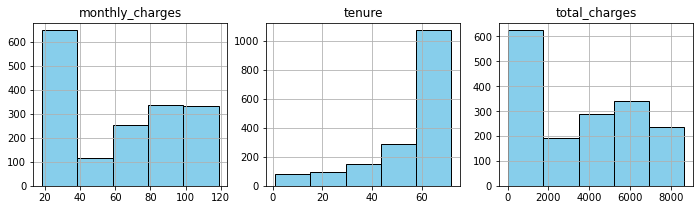

In [19]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(['monthly_charges', 'tenure', 'total_charges']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(1,4, plot_number)
    plt.title(col)
    series.hist(bins=5, color = "skyblue", ec="black")

Text(0.5, 1.0, 'Distribution of Total Charges')

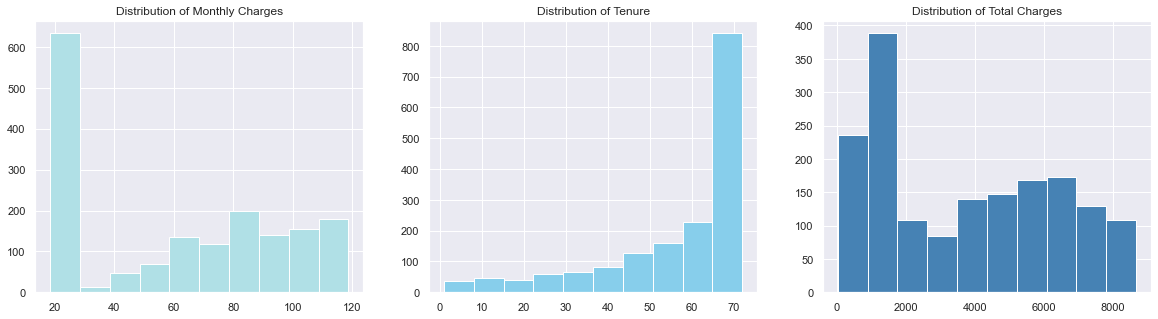

In [20]:
# This is just a way to make it look better in my opinion

plt.subplots(1, 3, figsize=(20,5), sharey=True)
plt.title('Initial Pokemon - 1st Generation')
sns.set(style="darkgrid")
# Monthly Charges
plt.subplot(1,3,1)
plt.hist(data=df, x='monthly_charges', color="powderblue")
plt.title('Distribution of Monthly Charges')

# Tenure
plt.subplot(1,3,2)
plt.hist(data=df, x='tenure', color="skyblue")
plt.title('Distribution of Tenure')

# Total Charges
plt.subplot(1,3,3)
plt.hist(data=df, x='total_charges', color="steelblue")
plt.title('Distribution of Total Charges')

Text(0.5, 1.0, 'Total Charges')

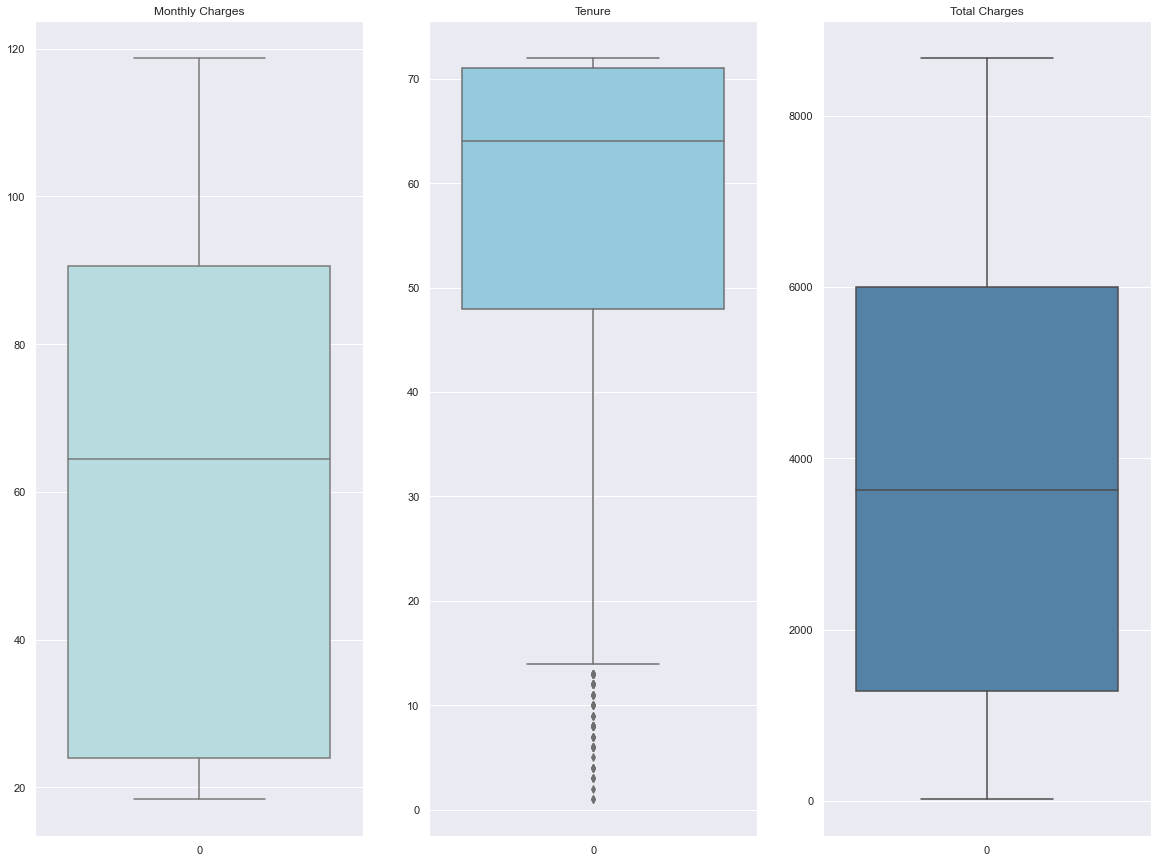

In [21]:
plt.subplots(1, 3, figsize=(20,15), sharey=True)
plt.title('Telco Data Boxplots')
sns.set(style="darkgrid")
# Monthly Charges
plt.subplot(1,3,1)
sns.boxplot(data=df.monthly_charges, color="powderblue")
plt.title('Monthly Charges')

# Tenure
plt.subplot(1,3,2)
sns.boxplot(data=df.tenure, color="skyblue")
plt.title('Tenure')

# Total Charges
plt.subplot(1,3,3)
sns.boxplot(data=df.total_charges, color="steelblue")
plt.title('Total Charges')


In [22]:
# Split the data into train, validate, and test
train, test = train_test_split(df, train_size=0.8, random_state=1234)
train, validate = train_test_split(train, train_size=0.7, random_state=1234)

In [23]:
train.head()

,customer_id,monthly_charges,tenure,total_charges
489,2999-AANRQ,71.05,21,1524.85
288,1813-JYWTO,80.45,72,5737.60
1618,9553-DLCLU,88.95,13,1161.75
980,5915-ANOEI,79.15,70,5536.50
595,3597-YASZG,104.45,70,7349.35


In [24]:
validate.head()

,customer_id,monthly_charges,tenure,total_charges
1007,6060-QBMGV,19.85,70,1433.80
102,0603-TPMIB,25.45,59,1534.05
587,3549-ZTMNH,24.00,12,269.65
1583,9365-CSLBQ,24.35,71,1654.60
1689,9959-WOFKT,106.70,71,7382.25


In [25]:
test.head()

,customer_id,monthly_charges,tenure,total_charges
1504,8879-XUAHX,116.25,71,8564.75
1440,8468-FZTOE,74.35,72,5237.40
406,2434-EEVDB,94.60,64,5948.70
684,4111-BNXIF,59.55,67,4103.90
14,0078-XZMHT,85.15,72,6316.20


3. End with a python file wrangle.py that contains the function, wrangle_telco(), that will acquire the data and return a dataframe cleaned with no missing values.

In [26]:
def acquire_telco():
    '''
    Grab our data from SQL
    '''
    sql_query = '''select customer_id, monthly_charges, tenure, total_charges
    from customers
    join contract_types using(contract_type_id)
    where contract_type = "Two Year"
    '''
    connection = f'mysql+pymysql://{user}:{password}@{host}/telco_churn'
    df = pd.read_sql(sql_query, connection)
    return df

In [27]:
def split_telco(df):
    '''
    split our data
    takes in a pandas dataframe
    returns 3 panda dataframs:
        train
        test
        validate
    '''
    train, test = train_test_split(df, train_size=0.8, random_state=1234)
    train, validate = train_test_split(train, train_size=0.7, random_state=1234)
    return train, validate, test

In [28]:
def wrangle_telco():
    '''
    Pull data form 'acquire_telco'
    Takes in df of students grades and cleans the data
    replace empty cells with null values
    drop null values
    convert 'total_charges' from dtype object to float
    
    returns a clean df as a pandas df
    '''
    # get data from acquire_telco
    df = acquire_telco()
    # replace empty cells with null values
    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    # drop null values
    df = df.dropna()
    # convert 'total_charges' from dtype object to float
    df['total_charges'] = df.total_charges.dropna().astype('float')
    
    return df

In [29]:
def wrangle_telco():
    '''
    Pulls data form acuire.py's 'acquire_telco'
    Takes in df of students grades and cleans the data
    replace empty cells with null values
    drop null values
    convert 'total_charges' from dtype object to float
    split our data
    takes in a pandas dataframe
    returns 3 panda dataframs:
        train
        test
        validate
    '''
    df = clean_telco(acquire.acquire_telco())
    return split_telco(df)